# <center>  Analysis of Hanly & Tubbs Fires  

In [2]:
## HanlyTubbsAnalysis.py
## by: Holli Knight

In [3]:
## Import packages
import os
import requests
import pandas as pd
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry
import contextily as cx
import xarray as xr
import urllib
import netCDF4
import seaborn as sns
#%matplotlib widget
import ipywidgets as widgets

In [18]:
## Set variables

data_dir = '/Users/27249/Desktop/GitRepos/HanlyTubbsFires/02_Data/'

#for file in os.

In [5]:
### Access API

##Request data from Ca.gov, convert to json, and select relevant fire data

In [6]:
def UrlToDf(url):
    ## Use requests package to access API
    request = requests.get(url)
    
    ## Convert to JSON
    data = request.json()
    
    ## Select feature set
    features = data['features']
    
    ## Normalize and convert to DataFrame
    df = pd.DataFrame(pd.json_normalize(features))
    
    return df

In [7]:
url_1960s = "https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters/MapServer/7/query?where=1%3D1&outFields=*&outSR=4326&f=json"
df60 = UrlToDf(url_1960s)

url_2010s = "https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters/MapServer/2/query?where=1%3D1&outFields=*&outSR=4326&f=json"
df10 = UrlToDf(url_2010s)


In [8]:
## Append datasets & select fires of interest
df_append = df60.append(df10)
fire_df = df_append.loc[(df_append['attributes.FIRE_NAME'] == "C. HANLY") | 
                        (df_append['attributes.FIRE_NAME'] == 'TUBBS')]

/var/folders/lk/ty0zvm7x1711sth69gl25hsr0000gr/T/ipykernel_83084/2079258485.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df60.append(df10)


In [9]:
### Preprocessing

## Format geometry data

In [10]:
def MakeGeo(df, geo_column, shape, spacial_ref):
    ## inputs: dataframe, initial geometry column, shapely geometry, and geometry spacial reference
    
    ## Reset index for joining data
    df = df.reset_index()
    
    ## Unstack nested list in Esri Geometry Column 
    df_geometry = df[geo_column]
    df = df.join(pd.DataFrame(df_geometry.apply(pd.Series).stack()).reset_index())
    
    ## Rename new column
    df.columns = [*df.columns[:-1], 'geom']
    ## Tranform column to list of tuples (required for polygon data)
    df['geom'] = list(tuple(x) for x in df['geom'])
    
    ## Create geometry by calling shapely.geometry
    df['geometry'] = df.apply(lambda row: shape(row['geom']), axis=1)
    
    ## Drop unnecessary column
    df = df.drop(columns = ['level_0', 'level_1', 'geom'])
    
    ## Set geometry column and specify the geometry's spacial reference
    gdf = df.set_geometry("geometry", crs = spacial_ref)
    ## Return GeoDataFrame
    return gdf


In [11]:
fire_gdf = MakeGeo(fire_df, 'geometry.rings', shapely.geometry.Polygon, "EPSG:4326")

In [12]:
## Inspect Hanly Geometry
#fire_gdf['geometry'][0]

In [13]:
## Inspect Tubbs Geometry
#fire_gdf['geometry'][1]

In [14]:
## Check data types
#fire_gdf.dtypes

### Plotting Fire Shapes

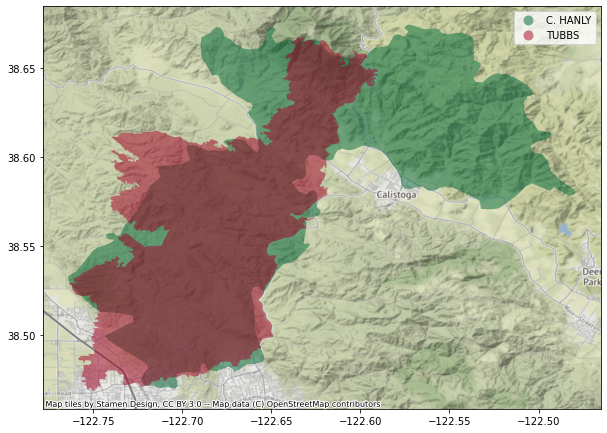

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

fire_gdf.plot(ax=ax, column='attributes.FIRE_NAME', cmap='RdYlGn_r',legend=True,  alpha=0.5, 
                 legend_kwds={'loc': 'upper right'})


cx.add_basemap(ax, crs=fire_gdf.crs.to_string())


#plt.xlim(-122.8, -122.4)
#plt.ylim(38.35, 38.7)

plt.show()

### Weather Comparison

In [21]:
## function to take CSV file from github
import pandas as pd

def read_file(url):

    """
    Takes GitHub url as an argument,
    pulls CSV file located @ github URL.

    """

    url = url + "?raw=true"
    df = pd.read_csv(url)
    return df


# READ FILE FROM GITHUB REPO 
# CHANGE THE URL TO YOUR DATA LOCATION!
url = "https://github.com/hollifknight/HanlyTubbsVoilaHeroku/blob/master/weather_master.csv"

weather_df = read_file(url)

In [22]:
df2 = weather_df.copy()

df2['Tair_f_tavg'] = np.where(weather_df['Year']==1964, weather_df['Tair_f_tavg'], ((weather_df['Temp_Avg'] - 32) * 5/9 + 273.15))
df2['Wind_f_tavg'] = np.where(weather_df['Year']==1964, weather_df['Wind_f_tavg'], (weather_df['Wind_Avg']/ 2.237))
df2['Psurf_f_tavg'] = np.where(weather_df['Year']==1964, weather_df['Psurf_f_tavg'], (weather_df['Pressure_Avg']* 3386.39))
df2["Rainf_f_tavg"] = np.where(weather_df['Year']==1964, weather_df["Rainf_f_tavg"], ((weather_df['Precipitation'] / 86400) * 25.4))

In [23]:
variable_dict = dict({
"ACond_tavg" : "Aerodynamic conductance (m s-1)",
"AvgSurfT_tavg" : "Average surface skin temperature (K)",
"CanopInt_tavg" : "Plant canopy surface water (kg m-2)",
"ECanop_tavg" : "Canopy water evaporation (kg m-2 s-1)",
"ESoil_tavg" : "Direct evaporation from bare soil (kg m-2 s-1)",
"Evap_tavg" : "Evapotranspiration (kg m-2 s-1)",
"EvapSnow_tavg" : "Snow evaporation (kg m-2 s-1)",
"GWS_tavg" : "Ground water storage (mm)",
"LWdown_f_tavg" : "Downward longwave radiation flux (W m-2)",
"Lwnet_tavg" : "Net longwave radiation flux (W m-2)",
"Psurf_f_tavg" : "Surface air pressure (Pa)",
"Qair_f_tavg" : "Specific humidity (kg kg-1)",
"Qg_tavg" : "Ground heat flux (W m-2)",
"Qh_tavg" : "Sensible heat net flux (W m-2)",
"Qle_tavg" : "Latent heat net flux (W m-2)",
"Qs_tavg" : "Storm surface runoff (kg m-2 s-1)",
"Qsb_tavg" : "Baseflow-groundwater runoff (kg m-2 s-1)",
"Qsm_tavg" : "Snow melt (kg m-2 s-1)",
"Rainf_f_tavg" : "Total precipitation rate (kg m-2 s-1)",
"Rainf_tavg" : "Rain precipitation rate (kg m-2 s-1)",
"SnowDepth_tavg" : "Snow depth (m)",
"Snowf_tavg" : "Snow precipitation rate (kg m-2 s-1)",
"SnowT_tavg" : "Snow surface temperature (K)",
"SoilMoist_P_tavg" : "Profile soil moisture (kg m-2)",
"SoilMoist_RZ_tavg" : "Root zone soil moisture (kg m-2)",
"SoilMoist_S_tavg" : "Surface soil moisture (kg m-2)",
"SWdown_f_tavg" : "Downward shortwave radiation flux (W m-2)",
"SWE_tavg" : "Snow depth water equivalent (kg m-2)",
"Swnet_tavg" : "Net shortwave radiation flux (W m-2)", 
"Tair_f_tavg" : "Air temperature (K)",
"TVeg_tavg" : "Transpiration (kg m-2 s-1)",
"TWS_tavg" : "Terrestrial water storage (mm)",
"Wind_f_tavg" : "Wind speed (m s-1)"
})

In [24]:
df2 = df2.rename(columns = variable_dict)

df2.loc[:, "Net shortwave radiation flux (W m-2)":"Downward longwave radiation flux (W m-2)"] = df2.loc[:, "Net shortwave radiation flux (W m-2)":"Downward longwave radiation flux (W m-2)"].astype(float)


In [25]:
## create filter widget

var_keys = list(variable_dict.values())
Variable = widgets.Select(options=var_keys, 
                         layout = widgets.Layout(width='400px', height='200px'),
                         description="Feature", disabled=False)

## create and update plot with widget

def update_plot(Variable):
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.clear()
    
    hanly_start =  38 #263 # Sept. 19, 1964
    hanly_end = (hanly_start + 1)
    tubbs_start = 40 #281 # Oct. 8 - 31, 2017
    tubbs_end = (tubbs_start + 3)

        
    g1 = sns.lineplot(data=df2, x="Week", y=Variable, palette='RdBu', hue="Year", alpha=0.7, legend=True#, ci=None
                     )

    plt.axvspan(hanly_start, hanly_end, label="Hanly Fire", color="maroon", alpha=0.5)
    plt.axvspan(tubbs_start, tubbs_end, label = "Tubbs Fire", color="steelblue", alpha=0.5)


    plt.xlim(18, 44)
    plt.title(Variable +" by Week", fontsize=14)

    plt.xticks(np.arange(18, 46, 2), labels=['5/1', '5/15', '5/29', '6/12', '6/26', '7/10', '7/24', '8/7', '8/21', 
                                            '9/4', '9/18', '10/2', '10/16', '10/30'])
    plt.legend()
    plt.show()



### Weather Widget

In [26]:
display(widgets.interact(update_plot, Variable=Variable))

interactive(children=(Select(description='Feature', layout=Layout(height='200px', width='400px'), options=('Ae…

<function __main__.update_plot(Variable)>